# 2022-05-02• STA mean vs peak-to-peak

Peak-to-peak cannot distinguish excitatory vs inhibitory (it's just the height of the bump -- no matter whether it's upwards or downwards).

To do that, we might instead use sth like "either max-median or min-median, whatever's largest in absolute terms".

For now we don't try to detect this difference, and 'cheat' in our code (special-case the inhibitory / ptp case when comparing p-values with α).

## Setup

In [4]:
#

In [5]:
using Revise

In [6]:
using MyToolbox

In [7]:
using VoltageToMap

## Params

In [8]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
    80,
    320,
    1280,
    5200,  
];

In [10]:
get_params(N_exc) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc),
    ),
    conntest = ConnTestParams(STA_test_statistic="ptp")
);

In [11]:
paramsets = get_params.(N_excs);

In [12]:
dumps(paramsets[1])

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 0
  evaluation: EvaluationParams
    α: 0.05
    num_tested_

## Run

In [50]:
perfs = Vector()
for paramset in paramsets
    num_inputs = paramset.sim.input.N_conn
    @show num_inputs
    perf = performance_for(paramset)
    @show perf
    push!(perfs, perf)
    println()
end

num_inputs = 5
Running simulation: 100%|███████████████████████████████| Time: 0:00:10
Testing connections: 100%|██████████████████████████████| Time: 0:00:06
perf = (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.0)

num_inputs = 21
Running simulation: 100%|███████████████████████████████| Time: 0:00:10
Testing connections: 100%|██████████████████████████████| Time: 0:00:08
perf = (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.07499999999999996)

num_inputs = 100
Running simulation: 100%|███████████████████████████████| Time: 0:00:10
Testing connections: 100%|██████████████████████████████| Time: 0:00:15
perf = (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.07499999999999996)

num_inputs = 400
Running simulation: 100%|███████████████████████████████| Time: 0:00:15
Testing connections: 100%|██████████████████████████████| Time: 0:00:17
perf = (TPR_exc = 1.0, TPR_inh = 0.75, FPR = 0.125)

num_inputs = 1600
Running simulation: 100%|███████████████████████████████| Time: 0:00:45
Testing connections: 100%|████████

## Plot results

In [51]:
import PyPlot

In [52]:
using VoltageToMap.Plot

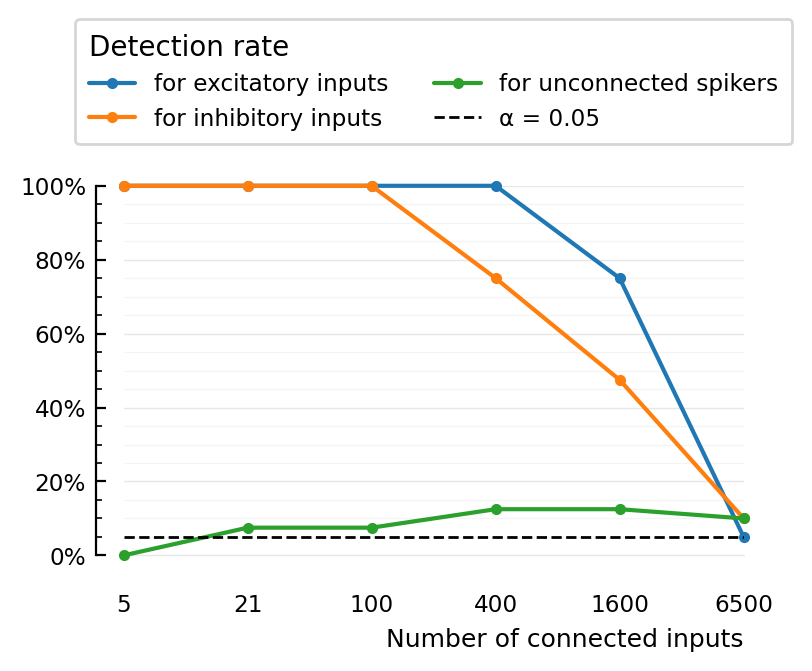

In [53]:
xlabels = [p.sim.input.N_conn for p in paramsets]
xticks = [1:length(xlabels);]
plot_detection_rate(detection_rate; kw...) = plot(
    xticks,
    detection_rate,
    ".-";
    ylim=(0, 1),
    xminorticks=false,
    clip_on=false,
    kw...
)
ax = plot_detection_rate([p.TPR_exc for p in perfs], label="for excitatory inputs")
     plot_detection_rate([p.TPR_inh for p in perfs], label="for inhibitory inputs")
     plot_detection_rate([p.FPR for p in perfs], label="for unconnected spikers")

@unpack α = paramsets[1].evaluation
ax.axhline(α, color="black", zorder=3, lw=1, linestyle="dashed", label=f"α = {α:.3G}")

# We don't use our `set`, as that undoes our `xminorticks=false` command (bug).
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("Number of connected inputs")
ax.yaxis.set_major_formatter(PyPlot.matplotlib.ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(false)
ax.tick_params(bottom=false)
ax.spines["bottom"].set_visible(false)
l = ax.legend(title="Detection rate", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.1));
l._legend_box.align = "left";

## [experiment with JLD]

In [9]:
simparams = SimParams()

SimParams
  duration: Float64 10.0
  Δt: Float64 0.0001
  num_timesteps: Int64 100000
  rngseed: Int64 0
  input: PoissonInputParams
  synapses: SynapseParams
  izh_neuron: IzhikevichParams
  imaging: VoltageImagingParams


In [19]:
cached(sim, [simparams])

Running simulation: 100%|███████████████████████████████| Time: 0:00:02
Saving output at C:\Users\lpxtf3\.phdcache\sim\f0f0133006d71ff8.jld2 … done


(t = 0.0:0.0001:9.9999, v = [-0.06, -0.06, -0.06, -0.059998499999999996, -0.05999554250146071, -0.05999116919268283, -0.059985420949328176, -0.05998033892943164, -0.05997390483727574, -0.05996615837956835  …  -0.051569570355458685, -0.05156916502748691, -0.05156820579701809, -0.051566703387809436, -0.05156466832566514, -0.051564743591193576, -0.0515642560014237, -0.05156584912090414, -0.05156685005100639, -0.05156727021363436], vi = [-0.05757587363816176, -0.06346682170719456, -0.0451659909400253, -0.05756979600936673, -0.048797010341476474, -0.061702405563821, -0.07386042425783401, -0.06032683409766343, -0.0422456544695759, -0.06727810309083061  …  -0.04307534263893664, -0.06532468910147522, -0.04369371068839138, -0.030218291917927624, -0.052239527228263215, -0.056862011763742996, -0.04992458470683031, -0.048951932823367524, -0.04760287086959901, -0.03519390455417906], input_spikes = (conn = (exc = [[0.24819999999998898, 1.2100999999998832, 2.0953999999999975, 2.4546000000007555, 2.80

In [20]:
cached(sim, [simparams])

Loading output from C:\Users\lpxtf3\.phdcache\sim\f0f0133006d71ff8.jld2 … done


(t = 0.0:0.0001:9.9999, v = [-0.06, -0.06, -0.06, -0.059998499999999996, -0.05999554250146071, -0.05999116919268283, -0.059985420949328176, -0.05998033892943164, -0.05997390483727574, -0.05996615837956835  …  -0.051569570355458685, -0.05156916502748691, -0.05156820579701809, -0.051566703387809436, -0.05156466832566514, -0.051564743591193576, -0.0515642560014237, -0.05156584912090414, -0.05156685005100639, -0.05156727021363436], vi = [-0.05757587363816176, -0.06346682170719456, -0.0451659909400253, -0.05756979600936673, -0.048797010341476474, -0.061702405563821, -0.07386042425783401, -0.06032683409766343, -0.0422456544695759, -0.06727810309083061  …  -0.04307534263893664, -0.06532468910147522, -0.04369371068839138, -0.030218291917927624, -0.052239527228263215, -0.056862011763742996, -0.04992458470683031, -0.048951932823367524, -0.04760287086959901, -0.03519390455417906], input_spikes = (conn = (exc = [[0.24819999999998898, 1.2100999999998832, 2.0953999999999975, 2.4546000000007555, 2.80

In [15]:
@withfb "sl" sleep(3)

sl … done


In [37]:
output = sim(simparams);

Running simulation: 100%|███████████████████████████████| Time: 0:00:02


In [38]:
dir = joinpath(homedir(), ".phdcache")
mkpath(dir)
path = joinpath(dir, string(hash(simparams), base=16) * ".hdf5")

"C:\\Users\\lpxtf3\\.phdcache\\58a8902d1513fbbc.hdf5"

- https://github.com/JuliaIO/JLD.jl
- https://docs.julialang.org/en/v1/base/file/#Base.Filesystem.isfile
- https://github.com/JuliaIO/JLD.jl/blob/master/doc/jld.md

In [79]:
joinpath(homedir(), nothing)

LoadError: MethodError: no method matching joinpath(::String, ::Nothing)
[0mClosest candidates are:
[0m  joinpath([91m::AbstractString...[39m) at C:\Julia-1.7.1\share\julia\base\path.jl:327

In [57]:
jldsave(path2; simparams, output)

In [46]:
path2 = joinpath(dir, "blah.jld2")

"C:\\Users\\lpxtf3\\.phdcache\\blah.jld2"

In [47]:
jldsave(path2; output)

In [59]:
l = load(path2)

Dict{String, Any} with 2 entries:
  "output"    => (t = 0.0:0.0001:9.9999, v = [-0.06, -0.06, -0.06, -0.0599985, …
  "simparams" => SimParams(10.0, 0.0001, 100000, 0, PoissonInputParams(100, 520…

In [60]:
o = l["output"];

In [66]:
homedir() / p".phdcache"

LoadError: MethodError: no method matching /(::String, ::WindowsPath)
[0mClosest candidates are:
[0m  /(::Any, [91m::ChainRulesCore.AbstractThunk[39m) at C:\Users\lpxtf3\.julia\packages\ChainRulesCore\IzITE\src\tangent_types\thunks.jl:35
[0m  /([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at C:\Users\lpxtf3\.julia\packages\ChainRulesCore\IzITE\src\tangent_types\thunks.jl:34
[0m  /([91m::ChainRulesCore.AbstractZero[39m, ::Any) at C:\Users\lpxtf3\.julia\packages\ChainRulesCore\IzITE\src\tangent_types\abstract_zero.jl:25
[0m  ...

In [63]:
o.input_spikes.conn.exc[1]

20-element Vector{Float64}:
 0.24819999999998898
 1.2100999999998832
 2.0953999999999975
 2.4546000000007555
 2.805400000001496
 3.173300000002272
 3.5071000000029766
 3.8602000000037218
 4.2827000000033575
 4.89950000000192
 5.453500000000629
 5.809899999999798
 6.181899999998931
 6.7601999999975835
 7.154199999996665
 7.556099999995729
 8.330199999993924
 8.661399999993153
 9.034399999992283
 9.394599999991444